In [4]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.misc
import imageio
import cv2
from PIL import Image
import sys
import os
import csv
import pickle
datapath = "/home/kenny/Dropbox/Coding/MLArtUIowa/Data/" #HomeDesktop

In [5]:
with open(datapath + "data.pkl", "rb") as fh:
    data = pickle.load(fh)

In [6]:
label_grade_pixels = data[0]
grade_one_hot = data[1]
train_imgs = data[2]
train_grades = label_grade_pixels[:, 1]

image_size = 12
no_of_different_lables = 10
image_pixels = image_size**2

In [7]:
import numpy as np
from scipy.special import expit as activation_function
from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd,
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)

class NeuralNetwork:
        
    
    def __init__(self, 
                 network_structure, # ie. [input_nodes, hidden1_nodes, ... , hidden_n_nodes, output_nodes]
                 learning_rate,
                 bias=None
                ):  

        self.structure = network_structure
        self.learning_rate = learning_rate 
        self.bias = bias
        self.create_weight_matrices()

    
    
    def create_weight_matrices(self):
        X = truncated_normal(mean=2, sd=1, low=-0.5, upp=0.5)
        
        bias_node = 1 if self.bias else 0
        self.weights_matrices = []    
        layer_index = 1
        no_of_layers = len(self.structure)
        while layer_index < no_of_layers:
            nodes_in = self.structure[layer_index-1]
            nodes_out = self.structure[layer_index]
            n = (nodes_in + bias_node) * nodes_out
            rad = 1 / np.sqrt(nodes_in)
            X = truncated_normal(mean=2, sd=1, low=-rad, upp=rad)
            wm = X.rvs(n).reshape((nodes_out, nodes_in + bias_node))
            self.weights_matrices.append(wm)
            layer_index += 1

        
        
    def train_single(self, input_vector, target_vector):
        # input_vector and target_vector can be tuple, list or ndarray
                                       
        no_of_layers = len(self.structure)        
        input_vector = np.array(input_vector, ndmin=2).T

        layer_index = 0
        # The output/input vectors of the various layers:
        res_vectors = [input_vector]          
        while layer_index < no_of_layers - 1:
            in_vector = res_vectors[-1]
            if self.bias:
                # adding bias node to the end of the 'input'_vector
                in_vector = np.concatenate( (in_vector, 
                                             [[self.bias]]) )
                res_vectors[-1] = in_vector
            x = np.dot(self.weights_matrices[layer_index], in_vector)
            out_vector = activation_function(x)
            res_vectors.append(out_vector)   
            layer_index += 1
        
        layer_index = no_of_layers - 1
        target_vector = np.array(target_vector, ndmin=2).T
         # The input vectors to the various layers
        output_errors = target_vector - out_vector  
        while layer_index > 0:
            out_vector = res_vectors[layer_index]
            in_vector = res_vectors[layer_index-1]

            if self.bias and not layer_index==(no_of_layers-1):
                out_vector = out_vector[:-1,:].copy()

            tmp = output_errors * out_vector * (1.0 - out_vector)     
            tmp = np.dot(tmp, in_vector.T)
            
            #if self.bias:
            #    tmp = tmp[:-1,:] 
                
            self.weights_matrices[layer_index-1] += self.learning_rate * tmp
            
            output_errors = np.dot(self.weights_matrices[layer_index-1].T, 
                                   output_errors)
            if self.bias:
                output_errors = output_errors[:-1,:]
            layer_index -= 1
            

       

    def train(self, data_array, 
              labels_one_hot_array,
              epochs=1,
              intermediate_results=False):
        intermediate_weights = []
        for epoch in range(epochs):  
            for i in range(len(data_array)):
                self.train_single(data_array[i], labels_one_hot_array[i])
            if intermediate_results:
                intermediate_weights.append((self.wih.copy(), 
                                             self.who.copy()))
        return intermediate_weights      
        

               
    
    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray

        no_of_layers = len(self.structure)
        if self.bias:
            # adding bias node to the end of the inpuy_vector
            input_vector = np.concatenate( (input_vector, [self.bias]) )
        in_vector = np.array(input_vector, ndmin=2).T

        layer_index = 1
        # The input vectors to the various layers
        while layer_index < no_of_layers:
            x = np.dot(self.weights_matrices[layer_index-1], 
                       in_vector)
            out_vector = activation_function(x)
            
            # input vector for next layer
            in_vector = out_vector
            if self.bias:
                in_vector = np.concatenate( (in_vector, 
                                             [[self.bias]]) )            
            
            layer_index += 1
  
    
        return out_vector
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [10]:
#testing to see how the number of epochs affects the variance of machine assigned grades for variable node hidden layer
#learning rate = 0.005
results1 = []
for hidden_layer in [40, 60, 80]:
    for x in [200, 300, 500, 1000]:
            epochs = x
            ANN = NeuralNetwork(network_structure=[image_pixels, hidden_layer, 10],
                                       learning_rate=0.005,
                                       bias=None)
            ANN.train(train_imgs, grade_one_hot, epochs=epochs)
            ML_grades = []
            ML_accumulated_error = []
            for i in range(2000):
                res = ANN.run(train_imgs[i])
                error = np.abs(np.argmax(res)-train_grades[i])
                #print(np.argmax(res), np.max(res))
                ML_grades.append(np.argmax(res))
                ML_accumulated_error.append(error)
            #print(np.var(ML_grades))
            corrects, wrongs = ANN.evaluate(train_imgs, train_grades)
            print("Hidden Layer Nodes: " + str(hidden_layer) + "  Epochs: " + str(x) + "  Variance: " + str(np.var(ML_grades)) + "  Accuracy: " + str(corrects / ( corrects + wrongs)) + "  Average Error: " + str(np.sum(ML_accumulated_error)/2000))
            results1.append([hidden_layer, x, np.var(ML_grades), (corrects / ( corrects + wrongs)),(np.sum(ML_accumulated_error)/2000)])
            with open(datapath + 'NNs/pickled_NN_H' + str(hidden_layer) + 'E' + str(x), 'bw') as fh:
                data = (ANN)
                pickle.dump(data, fh)


Hidden Layer Nodes: 40  Epochs: 200  Variance: 3.3837497500000002  Accuracy: 0.22042682926829268  Average Error: 1.9015
Hidden Layer Nodes: 40  Epochs: 300  Variance: 3.4187559999999997  Accuracy: 0.22042682926829268  Average Error: 1.923
Hidden Layer Nodes: 40  Epochs: 500  Variance: 2.8461439999999993  Accuracy: 0.22560975609756098  Average Error: 1.871
Hidden Layer Nodes: 40  Epochs: 1000  Variance: 2.7011397500000003  Accuracy: 0.22835365853658537  Average Error: 1.8345
Hidden Layer Nodes: 60  Epochs: 200  Variance: 3.62469375  Accuracy: 0.21371951219512195  Average Error: 1.9335
Hidden Layer Nodes: 60  Epochs: 300  Variance: 3.8774000000000006  Accuracy: 0.2094512195121951  Average Error: 1.96
Hidden Layer Nodes: 60  Epochs: 500  Variance: 3.9066797500000003  Accuracy: 0.21798780487804878  Average Error: 1.9325
Hidden Layer Nodes: 60  Epochs: 1000  Variance: 3.3589437500000003  Accuracy: 0.22469512195121952  Average Error: 1.9065
Hidden Layer Nodes: 80  Epochs: 200  Variance: 3.66

In [19]:
results1[0][1]
y

[3.3837497500000002,
 3.4187559999999997,
 2.8461439999999993,
 2.7011397500000003]

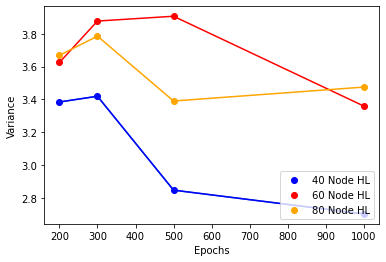

In [64]:
fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Variance')
x = [200,300,500,1000]

y40=[results1[0][2],results1[1][2],results1[2][2],results1[3][2]]
y60=[results1[4][2],results1[5][2],results1[6][2],results1[7][2]]
y80=[results1[8][2],results1[9][2],results1[10][2],results1[11][2]]
plt.plot(x, y)
plt.scatter(x, y40, label = '40 Node HL', color="blue")
plt.plot(x, y40, color="blue")
plt.scatter(x, y60, label = '60 Node HL', color="red")
plt.plot(x, y60, color="red")
plt.scatter(x, y80, label = '80 Node HL', color="orange")
plt.plot(x, y80, color="orange")
plt.legend(loc='lower right')
plt.savefig("Variance_vs_Epochs.pdf")

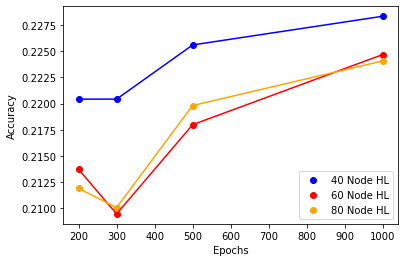

In [69]:
fig.clear()
fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
x = [200,300,500,1000]

y40=[results1[0][3],results1[1][3],results1[2][3],results1[3][3]]
y60=[results1[4][3],results1[5][3],results1[6][3],results1[7][3]]
y80=[results1[8][3],results1[9][3],results1[10][3],results1[11][3]]
plt.scatter(x, y40, label = '40 Node HL', color="blue")
plt.plot(x, y40, color="blue")
plt.scatter(x, y60, label = '60 Node HL', color="red")
plt.plot(x, y60, color="red")
plt.scatter(x, y80, label = '80 Node HL', color="orange")
plt.plot(x, y80, color="orange")
plt.legend(loc='lower right')
plt.savefig("Accuracy_vs_Epochs.pdf")

In [ ]:
#testing to see how the number of epochs affects the variance of machine assigned grades for variable node hidden layer
#learning rate = 0.005
for hidden_layer in [40, 60, 80]:
    for x in [2000, 4000, 8000, 16000]:
            epochs = x
            ANN = NeuralNetwork(network_structure=[image_pixels, hidden_layer, 10],
                                       learning_rate=0.005,
                                       bias=None)
            ANN.train(train_imgs, grade_one_hot, epochs=epochs)
            ML_grades = []
            ML_accumulated_error = []
            for i in range(2000):
                res = ANN.run(train_imgs[i])
                error = np.abs(np.argmax(res)-train_grades[i])
                #print(np.argmax(res), np.max(res))
                ML_grades.append(np.argmax(res))
                ML_accumulated_error.append(error)
            #print(np.var(ML_grades))
            corrects, wrongs = ANN.evaluate(train_imgs, train_grades)
            print("Hidden Layer Nodes: " + str(hidden_layer) + "  Epochs: " + str(x) + "  Variance: " + str(np.var(ML_grades)) + "  Accuracy: " + str(corrects / ( corrects + wrongs)) + "  Average Error: " + str(np.sum(ML_accumulated_error)/2000))
            with open(datapath + 'Data/pickled_NN_H' + str(hidden_layer) + 'E' + str(x), 'bw') as fh:
                data = (ANN)
                pickle.dump(data, fh)

In [18]:
#testing to see how the number of epochs affects the variance of machine assigned grades for variable node hidden layer
#learning rate = 0.01
for hidden_layer in [40, 60, 80]:
    for x in [200, 300, 500, 1000]:
            epochs = x
            ANN = NeuralNetwork(network_structure=[image_pixels, hidden_layer, 10],
                                       learning_rate=0.01,
                                       bias=None)
            ANN.train(train_imgs, grade_one_hot, epochs=epochs)
            ML_grades = []
            ML_accumulated_error = []
            for i in range(2000):
                res = ANN.run(train_imgs[i])
                error = np.abs(np.argmax(res)-train_grades[i])
                #print(np.argmax(res), np.max(res))
                ML_grades.append(np.argmax(res))
                ML_accumulated_error.append(error)
            #print(np.var(ML_grades))
            corrects, wrongs = ANN.evaluate(train_imgs, train_grades)
            print("Hidden Layer Nodes: " + str(hidden_layer) + "  Epochs: " + str(x) + "  Variance: " + str(np.var(ML_grades)) + "  Accuracy: " + str(corrects / ( corrects + wrongs)) + "  Average Error: " + str(np.sum(ML_accumulated_error)/2000))
            with open(datapath + 'Data/pickled_NN_H' + str(hidden_layer) + 'E' + str(x), 'bw') as fh:
                data = (ANN)
                pickle.dump(data, fh)

Hidden Layer Nodes: 40  Epochs: 200  Variance: 2.5001990000000003  Accuracy: 0.23823008849557523  Average Error: 1.92
Hidden Layer Nodes: 40  Epochs: 300  Variance: 1.107775  Accuracy: 0.23787610619469027  Average Error: 1.811
Hidden Layer Nodes: 40  Epochs: 500  Variance: 1.12193975  Accuracy: 0.2375221238938053  Average Error: 1.8405
Hidden Layer Nodes: 40  Epochs: 1000  Variance: 1.249975  Accuracy: 0.23858407079646018  Average Error: 1.838
Hidden Layer Nodes: 60  Epochs: 200  Variance: 3.6177040000000007  Accuracy: 0.23716814159292035  Average Error: 1.988
Hidden Layer Nodes: 60  Epochs: 300  Variance: 2.7228999999999997  Accuracy: 0.24  Average Error: 1.921
Hidden Layer Nodes: 60  Epochs: 500  Variance: 1.2218597500000004  Accuracy: 0.23893805309734514  Average Error: 1.8375
Hidden Layer Nodes: 60  Epochs: 1000  Variance: 1.6729749999999997  Accuracy: 0.23787610619469027  Average Error: 1.879
Hidden Layer Nodes: 80  Epochs: 200  Variance: 3.01229975  Accuracy: 0.24212389380530974 

In [ ]:
# From the previous testing, we'll stick with a single hidden layer neural net with the following parameters
# Input Layer: 144, Hidden Layer: 80, Output Layer: 10, Epochs: 1000, Training Rate: 0.01

In [19]:
epochs = 1000
hidden_layer = 80
ANN = NeuralNetwork(network_structure=[image_pixels, hidden_layer, 10],
                           learning_rate=0.01,
                           bias=None)
ANN.train(train_imgs, grade_one_hot, epochs=epochs)
ML_grades = []
ML_accumulated_error = []
for i in range(len(train_imgs)):
    res = ANN.run(train_imgs[i])
    error = np.abs(np.argmax(res)-train_grades[i])
    #print(np.argmax(res), np.max(res))
    ML_grades.append(np.argmax(res))
    ML_accumulated_error.append(error)
#print(np.var(ML_grades))
corrects, wrongs = ANN.evaluate(train_imgs, train_grades)
print("Hidden Layer Nodes: " + str(hidden_layer) + "  Epochs: " + str(epochs) + "  Variance: " + str(np.var(ML_grades)) + "  Accuracy: " + str(corrects / ( corrects + wrongs)) + "  Average Error: " + str(np.sum(ML_accumulated_error)/len(train_imgs)))
with open(datapath + 'Data/pickled_NN_H' + str(hidden_layer) + 'E' + str(x), 'bw') as fh:
                data = (ANN)
                pickle.dump(data, fh)

Hidden Layer Nodes: 80  Epochs: 1000  Variance: 1.1774546479755656  Accuracy: 0.2375221238938053  Average Error: 1.848849557522124


In [20]:
epochs = 200
ANN = NeuralNetwork(network_structure=[image_pixels, 60, 10],
                           learning_rate=0.01,
                           bias=None)
ANN.train(train_imgs, grade_one_hot, epochs=epochs)
ML_grades = []
ML_accumulated_error = []
for i in range(len(train_imgs)):
    res = ANN.run(train_imgs[i])
    error = np.abs(np.argmax(res)-train_grades[i])
    #print(np.argmax(res), np.max(res))
    ML_grades.append(np.argmax(res))
    ML_accumulated_error.append(error)
#print(np.var(ML_grades))
corrects, wrongs = ANN.evaluate(train_imgs, train_grades)
print("Hidden Layer Nodes: " + str(60) + "  Epochs: " + str(epochs) + "  Variance: " + str(np.var(ML_grades)) + "  Accuracy: " + str(corrects / ( corrects + wrongs)) + "  Average Error: " + str(np.sum(ML_accumulated_error)/len(train_imgs)))
with open(datapath + 'Data/pickled_NN_H' + str(hidden_layer) + 'E' + str(x), 'bw') as fh:
                data = (ANN)
                pickle.dump(data, fh)

Hidden Layer Nodes: 60  Epochs: 200  Variance: 2.8898618842509203  Accuracy: 0.24106194690265487  Average Error: 1.887433628318584


In [21]:
for i in range(200):
    res = ANN.run(train_imgs[i])
    print(train_grades[i], np.argmax(res), np.max(res))

6.0 5 0.2041063059137605
4.0 5 0.20116665710273413
5.0 5 0.27098035435997414
6.0 5 0.19675550352743237
7.0 5 0.31202765609357275
2.0 5 0.17588353349252994
3.0 1 0.18544674303038455
6.0 5 0.1688580148047821
5.0 5 0.20540441004776944
4.0 3 0.16660650044973896
4.0 9 0.23640304042938384
4.0 9 0.19437179541834232
3.0 5 0.24159251989714384
3.0 5 0.2941112317793242
6.0 5 0.2812749677104089
7.0 7 0.24806136277335572
5.0 5 0.31488712373419664
4.0 5 0.23109467325139363
7.0 2 0.16605633226689887
5.0 2 0.21860308277353122
4.0 5 0.18053281212527902
6.0 5 0.3450282253448238
4.0 2 0.21598532936276824
4.0 5 0.2335041751185809
3.0 5 0.18661256615565971
2.0 2 0.1737663944194469
2.0 2 0.24869081555852482
7.0 5 0.2262431602699008
5.0 2 0.17661197530799574
5.0 5 0.2725244668172836
4.0 5 0.2272957328685895
8.0 5 0.2219171275728048
5.0 5 0.2312724500962502
4.0 5 0.19713691744079317
3.0 3 0.27593187505567135
5.0 5 0.2292209184352885
3.0 2 0.2652575829796501
4.0 2 0.2072916433936481
7.0 5 0.2521788604845556
6.

In [22]:
with open(datapath + "Code/pickled_5000imgs.pkl", "rb") as fh:
    data1 = pickle.load(fh)

In [23]:
ML_assigned_grades = []
for i in range(len(data1[1])):
    res = ANN.run(data1[1][i])
    print(np.argmax(res), np.max(res))
    ML_assigned_grades.append(np.argmax(res))

5 0.24361833663380714
5 0.22081525645180503
5 0.23382086358277598
5 0.25117984914553737
5 0.21793607942273976
5 0.27501683438366276
3 0.19667495377906236
5 0.15898872100201253
5 0.17458986236769997
6 0.17751881987211265
5 0.2291874413438959
3 0.2038755512034841
5 0.27587306736406425
5 0.25047159346710784
3 0.24254101502517098
5 0.29613739583841536
5 0.16169764320411514
1 0.19816678316750633
5 0.2332505387992316
5 0.18014946273360224
5 0.26244400965002607
5 0.20165171280583427
5 0.30632090705570886
5 0.21534175998364188
2 0.20732206387112875
5 0.17217145363895917
9 0.18571387152942745
3 0.1852086632327164
3 0.18771446879105394
5 0.2022375155150061
2 0.23469613515906215
3 0.20060784132487053
5 0.16217457847566222
5 0.2251099003035664
5 0.2728521714710787
5 0.2547572881973813
5 0.2400646530118869
2 0.17217066435626427
5 0.2773993325844541
5 0.2293440643358746
5 0.1777100108516993
6 0.1432010970033567
5 0.2133296690938305
5 0.27009683637201065
5 0.29030155886331804
3 0.1863666619023827
5 0

In [24]:
indices_of_nines = [i for i, x in enumerate(ML_assigned_grades) if x == 9]
indices_of_zeros = [i for i, x in enumerate(ML_assigned_grades) if x == 0]

In [25]:
print(len(indices_of_nines))
print(len(indices_of_zeros))

27
19


In [ ]:
indices_of_nines

In [ ]:
indices_of_zeros

In [ ]:
from shutil import copyfile
best_list = []
for x in range(len(indices_of_nines)):
    copyfile(datapath + "Code/randomlinegen_archive/yim" + str(indices_of_nines[x]) + ".png", datapath + "Code/results/best/yim" + str(indices_of_nines[x]) + ".png")
    

best_list = []
for x in range(len(indices_of_zeros)):
    copyfile(datapath + "Code/randomlinegen_archive/yim" + str(indices_of_zeros[x]) + ".png", datapath + "Code/results/worst/yim" + str(indices_of_zeros[x]) + ".png")

In [ ]:
with open(datapath + 'Data/pickled_NN.pkl', 'bw') as fh:
    data = (ANN)
    pickle.dump(data, fh)